In [1]:
import sys, os
#restrict gpu usage
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch, torchvision
print('PyTorch version:          ', torch.__version__)
import pytorch_lightning as pl
print('PyTorch Lightning version:', pl.__version__)

import glob, tempfile
from pylab import *
import dataset, detector, util, evaluation

import PIL
PIL.Image.MAX_IMAGE_PIXELS = None #Needed to open large images

import warnings
warnings.simplefilter("ignore")

PyTorch version:           1.6.0+cu101
PyTorch Lightning version: 1.0.6


***
**Data collection**

In [2]:
IMAGEFILES    = sorted(glob.glob('data/conifer/train/*.jpg', recursive=True))
LABELFILES    = sorted(glob.glob('data/conifer/train/*.png', recursive=True))

print(f'Found {len(IMAGEFILES)} images and {len(LABELFILES)} annotations')
assert len(IMAGEFILES) == len(LABELFILES)

Found 31 images and 31 annotations


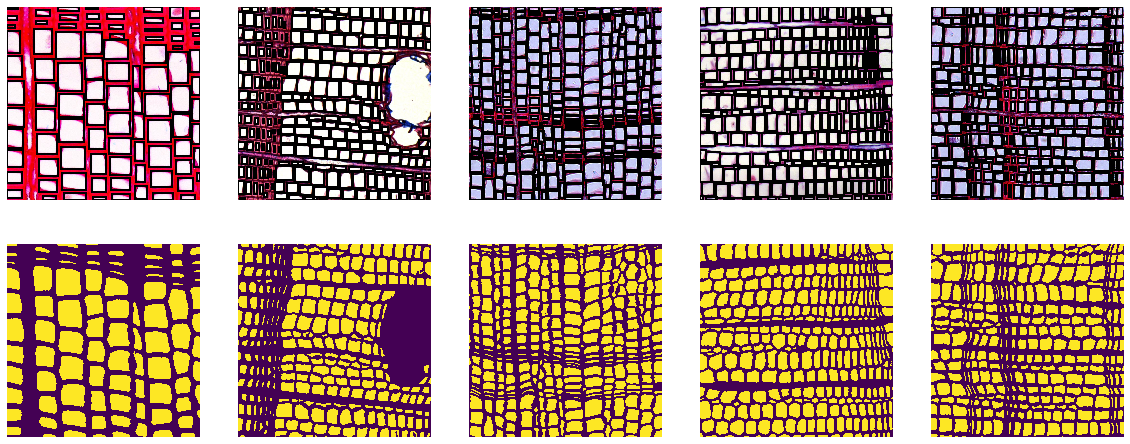

In [3]:
#example images
PATCHSIZE = 800
ds = dataset.Dataset(IMAGEFILES, LABELFILES, patchsize=PATCHSIZE, augment=True)

figure(0, (20,8))
for i in range(5):
    j     = np.random.randint(len(ds))
    a0,b0 = ds[j]
    subplot(2,5,i+1);   imshow(a0.transpose(1,2,0)); axis('off'); 
    [util.draw_box(b.numpy(), color='k', linewidth=2) for b in b0['boxes'] ];
    if len(b0['masks']):
        subplot(2,5,i+1+5); imshow(b0['masks'].max(0)[0].numpy()); axis('off');

***
**Training**

In [4]:
basemodel = detector.create_conifer_basemodel()
trainer   = detector.create_trainer(epochs=20)
loader    = dataset.create_dataloader(ds, shuffle=True, batchsize=1)
trainer.fit(detector.TrainingModel(basemodel), loader)
basemodel.cpu().eval();

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | basemodel | MaskRCNN | 44 M  


[0000] loss:  1.36000 | loss_classifier_step:  0.12720 | loss_box_reg_step:  0.15509 | loss_mask_step:  0.19390 | loss_objectness_step:  0.26240 | loss_rpn_box_reg_step:  0.26041 | loss_classifier_epoch:  1.13565 | loss_box_reg_epoch:  0.36366 | loss_mask_epoch:  0.35459 | loss_objectness_epoch:  1.36928 | loss_rpn_box_reg_epoch:  0.25900
[0001] loss:  0.88800 | loss_classifier_step:  0.21075 | loss_box_reg_step:  0.28532 | loss_mask_step:  0.29673 | loss_objectness_step:  0.15454 | loss_rpn_box_reg_step:  0.39607 | loss_classifier_epoch:  0.12541 | loss_box_reg_epoch:  0.22061 | loss_mask_epoch:  0.20574 | loss_objectness_epoch:  0.16137 | loss_rpn_box_reg_epoch:  0.19572
[0002] loss:  0.74700 | loss_classifier_step:  0.12371 | loss_box_reg_step:  0.27966 | loss_mask_step:  0.26096 | loss_objectness_step:  0.04631 | loss_rpn_box_reg_step:  0.08626 | loss_classifier_epoch:  0.09885 | loss_box_reg_epoch:  0.20906 | loss_mask_epoch:  0.19024 | loss_objectness_epoch:  0.12978 | loss_rpn_b

***
**Inference**

In [5]:
full_model = detector.FullDetector([basemodel], [PATCHSIZE], slacks=[128])
#or load saved model
#import pickle
#full_model = pickle.load(open('model.pkl','rb'))

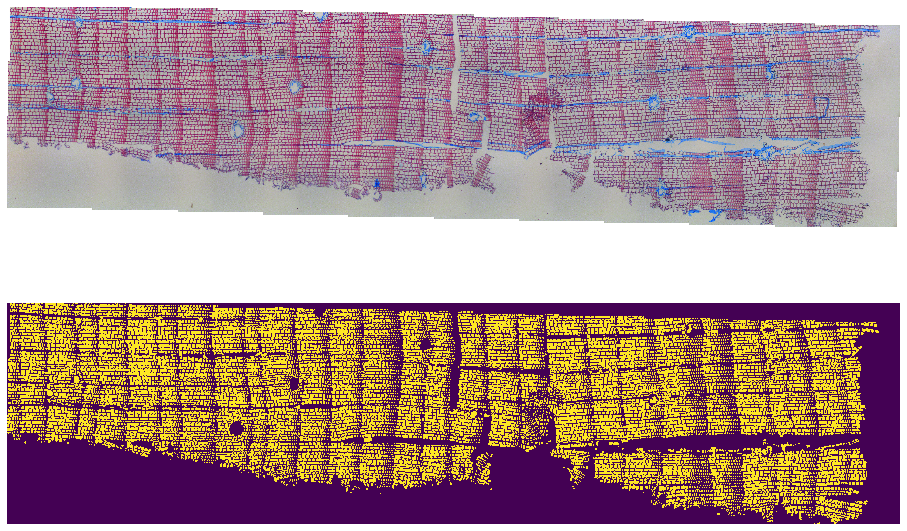

In [6]:
VALIDATION_IMAGE = 'data/conifer/val/ODPS017-2.1.jpg'

image   = full_model.load_image(VALIDATION_IMAGE)
output  = full_model.process_image(image, progress_callback=lambda x:print(f'Progress: {x*100:.1f}%', end='\r'))

figure(0, (16,10))
subplot(211);
imshow( image ); axis('off');
subplot(212);
imshow( output.squeeze() ); axis('off');

***

In [ ]:
#optionally save the model
#import pickle
#open('model.pkl','wb').write( pickle.dumps(full_model) )